In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain-groq langchain-community
#%pip langchain-anthropic
#%pip langchain-openai

In [3]:
import getpass
import os
from pprint import pprint
from google.colab import userdata
from getpass import getpass

In [4]:
os.environ['GROQ_API_KEY'] = getpass("GROQ_API_KEY")

GROQ_API_KEY··········


## Build a Basic Chatbot

In [12]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [13]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="gemma2-9b-it",
               temperature=0,
               max_tokens=256,
               max_retries=2)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [14]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

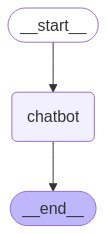

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
response = graph.invoke({"messages": [{"role": "user", "content": "What is agentic ai?"}]})

In [17]:
response['messages'][-1].content

"Agentic AI refers to a type of artificial intelligence that is designed to be **autonomous and goal-oriented**. \n\nHere's a breakdown:\n\n**Autonomous:** Agentic AI systems can operate independently, making decisions and taking actions without constant human intervention. They have the ability to perceive their environment, interpret information, and plan and execute actions to achieve their goals.\n\n**Goal-Oriented:** Agentic AI is driven by specific objectives. These goals can be pre-defined by humans or learned through interaction with the environment. The AI system will strive to achieve these goals through its actions.\n\n**Key Characteristics of Agentic AI:**\n\n* **Goal Recognition:** The ability to identify and understand the desired outcomes.\n* **Planning:** Developing a sequence of actions to achieve the goals.\n* **Action Execution:** Carrying out the planned actions in the real or simulated world.\n* **Learning and Adaptation:**  The capacity to learn from experiences a

In [18]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        response = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
        print("Assistant:", response['messages'][-1].content)
#        print("Assistant:", response['messages'])

    except:
        break

User: what is rag
Assistant: "Rag" can refer to several things, so to give you the best answer, I need more context! 

Could you please tell me what kind of rag you're interested in? For example, are you asking about:

* **A piece of cloth:** This is the most common meaning of "rag." It could be a torn piece of fabric used for cleaning, or a piece of cloth used in a specific craft or activity.
* **Ragtime music:** This is a genre of music that originated in the late 19th century and is characterized by its syncopated rhythms.
* **A derogatory term:** "Rag" can sometimes be used as a derogatory term for a person or thing that is considered worthless or inferior.
* **Something else entirely?**


Please provide more information so I can help you!

User: who won the icc t20 world cup in 2019
Assistant: **England** won the ICC T20 World Cup in 2019. 

User: who was the man of the match
Assistant: Please provide me with the context! 

I need to know what match you're referring to in order to

## Adding Tools

In [19]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition

In [20]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_tool_builder = StateGraph(State)

from langchain_groq import ChatGroq

llm = ChatGroq(model="gemma2-9b-it",
               temperature=0,
               max_tokens=256,
               max_retries=2)

In [22]:
os.environ['TAVILY_API_KEY'] = getpass("TAVILY_API_KEY")

TAVILY_API_KEY··········


In [23]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

In [24]:
llm_with_tools = llm.bind_tools(tools)

def chatbot_with_tools(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [25]:
graph_tool_builder.add_node("chatbotWithTools", chatbot_with_tools)

tool_node = ToolNode(tools=[tool])
graph_tool_builder.add_node("tools", tool_node)

graph_tool_builder.add_conditional_edges(
    "chatbotWithTools",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_tool_builder.add_edge("tools", "chatbotWithTools")
graph_tool_builder.set_entry_point("chatbotWithTools")
tool_graph = graph_tool_builder.compile()

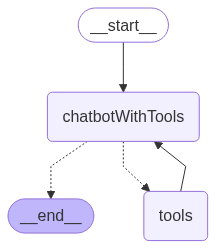

In [26]:
from IPython.display import Image, display

try:
    display(Image(tool_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

#        print("User: " + user_input)
        response = tool_graph.invoke({"messages": [{"role": "user", "content": user_input}]})
        print("Assistant:", response['messages'][-1].content)
#        print("Assistant:", response['messages'])

    except:
        break

User: who won the t20 world cup in 2025
Assistant: India 

User: who was the man of the match
Assistant: Raphinha 

User: quit
Goodbye!


## Adding Memory to Graph

In [28]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [29]:
graph_tool_builder = StateGraph(State)

graph_tool_builder.add_node("chatbotWithTools", chatbot_with_tools)

tool_node = ToolNode(tools=[tool])
graph_tool_builder.add_node("tools", tool_node)

graph_tool_builder.add_conditional_edges(
    "chatbotWithTools",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_tool_builder.add_edge("tools", "chatbotWithTools")
graph_tool_builder.set_entry_point("chatbotWithTools")
tool_graph = graph_tool_builder.compile(checkpointer=memory)

In [30]:
config = {"configurable": {"thread_id": "1"}}

In [31]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

#        print("User: " + user_input)
        response = tool_graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config)
        print("Assistant:", response['messages'][-1].content)
#        print("Assistant:", response['messages'])

    except:
        break

User: who won the t20 world cup in 2025
Assistant: India 

User: who was the man of the match
Assistant: Rohit Sharma 

User: quit
Goodbye!
